<a href="https://colab.research.google.com/github/lunaB/AI-Study/blob/master/7_mnist_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
from tqdm import tqdm_notebook

import numpy as np

torch.manual_seed(1)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
if device == 'cuda':
    torch.cuda.manual_seed_all(1)

In [0]:
mnist_train = datasets.MNIST(root='MNIST_data/',
                          train=True,
                          transform=transforms.ToTensor(),
                          download=True)

mnist_test = datasets.MNIST(root='MNIST_data/',
                         train=False,
                         transform=transforms.ToTensor(),
                         download=True)

In [3]:
print(mnist_train)
print(mnist_train.data.shape)
print(mnist_train.targets.shape)

Dataset MNIST
    Number of datapoints: 60000
    Root location: MNIST_data/
    Split: Train
    StandardTransform
Transform: ToTensor()
torch.Size([60000, 28, 28])
torch.Size([60000])


In [0]:
dataloader = torch.utils.data.DataLoader(mnist_train, 100, shuffle=True, drop_last=True)

In [0]:
class MnistModel(nn.Module):
    def __init__(self):
        super(MnistModel, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1), 
            nn.MaxPool2d(kernel_size=2, stride=2), 
            nn.ReLU()
        ).to(device)

        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1), 
            nn.MaxPool2d(kernel_size=2, stride=2), 
            nn.ReLU()
        ).to(device)

        self.fc = nn.Linear(7*7*64, 10, bias=True).to(device)

        nn.init.xavier_uniform_(self.fc.weight)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out).view(-1, 64*7*7)
        out = self.fc(out)
        return out

In [6]:
model = MnistModel()
optimizer = optim.Adam(model.parameters(), lr=0.001)
n_epoch = 15
for epoch in tqdm_notebook(range(n_epoch+1)):
    model.train()
    batch_loss = 0
    for idx, mini_batch in enumerate(dataloader):
        x_train, y_train = mini_batch
        x_train = x_train.view(-1,1,28,28).to(device)
        y_train = y_train.to(device)
        
        pred = model(x_train)

        loss = F.cross_entropy(pred, y_train)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        batch_loss += loss.item()

    print('epoch :',epoch, 'loss :', batch_loss/len(dataloader))
    batch_loss = 0

epoch : 0 loss : 0.2232148799703767
epoch : 1 loss : 0.06365160957405654
epoch : 2 loss : 0.044703641698385276
epoch : 3 loss : 0.03672968107644314
epoch : 4 loss : 0.03151800505428885
epoch : 5 loss : 0.024984735957017012
epoch : 6 loss : 0.021822289816045667
epoch : 7 loss : 0.018702491736185038
epoch : 8 loss : 0.015166305340341447
epoch : 9 loss : 0.01283841694452955
epoch : 10 loss : 0.011873309638855668
epoch : 11 loss : 0.009201796855049906
epoch : 12 loss : 0.008271389397574845
epoch : 13 loss : 0.0069792316619502045
epoch : 14 loss : 0.005447321597375776
epoch : 15 loss : 0.00544529378616365



tensor(5, device='cuda:0')


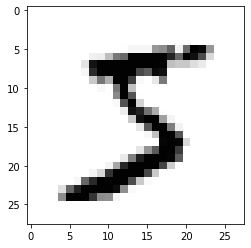

In [7]:
model.eval()
x_train, y_train = dataloader.dataset[0]
data = model(x_train.view(-1, 1, 28, 28).to(device)).detach()[0]
print(torch.argmax(data))
plt.imshow(x_train[0], cmap='Greys')
plt.show()

In [8]:
dataloader = torch.utils.data.DataLoader(mnist_train, 100, shuffle=True, drop_last=True)
model.eval()
with torch.no_grad():
    tmp = []
    for data in dataloader:
        x_data, y_data = data
        pred = model(x_data.view(-1, 1, 28, 28).float().to(device))
        tmp.append((y_data.to(device) == torch.argmax(pred, 1)).float().mean().item())
    print('Train Accuracy : %.2f%%'%(np.array(tmp).mean()*100))

Train Accuracy : 99.89%


In [9]:
model.eval()
dataloader = torch.utils.data.DataLoader(mnist_test, 100, shuffle=True, drop_last=True)
with torch.no_grad():
    tmp = []
    for data in dataloader:
        x_data, y_data = data
        pred = model(x_data.view(-1, 1, 28, 28).float().to(device))
        tmp.append((y_data.to(device) == torch.argmax(pred, 1)).float().mean().item())
    print('Test Accuracy : %.2f%%'%(np.array(tmp).mean()*100))

Test Accuracy : 99.16%
